
# pPXF: Reflection-symmetric LOSVD and sky fit

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

This procedure illustrates (and tests) both
  1. The simultaneous fit of two reflection-symmetric LOSVDs;
  2. The fit of the sky spectrum together with the templates.

### MODIFICATION HISTORY

- V1.0.0: Written by Michele Cappellari, based on a previous IDL procedure.
      Oxford, 20 April 2017
- V1.0.1: Updated MILES file names. MC, Oxford, 29 November 2017
- V1.0.2: Changed imports for pPXF as a package.
      Make file paths relative to the pPXF package to be able to run the
      example unchanged from any directory. MC, Oxford, 17 April 2018
- V1.0.3: Dropped legacy Python 2.7 support. MC, Oxford, 10 May 2018
- V1.0.4: Fixed clock DeprecationWarning in Python 3.7.
      MC, Oxford, 27 September 2018
- V1.1.0: Use E-Miles spectral library. MC, Oxford, 16 March 2022
- V1.2.0: Make single call of new log_rebin for all templates.
      MC, Oxford, 31 August 2023
- V1.3.0: Use the new `sps_util` instead of `miles_util`. 
      MC, Oxford, 12 November 2023
- V1.3.1: Use updated Numpy `default_rng` random generator. 
      MC, Oxford, 28 May 2024
___

In [1]:
from pathlib import Path
from time import perf_counter as clock
from urllib import request

import numpy as np
from scipy import signal
from numpy.polynomial import legendre
import matplotlib.pyplot as plt

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

## Read the mock spectrum

In [2]:
lam_range_temp = [3500, 7500]
sps_name = 'emiles'
velscale = 70   # km/s

Read SPS models file from my GitHub if not already in the `pPXF` package dir.
The SPS model files are also available on my [GitHub Page](https://github.com/micappe/ppxf_data).

In [3]:
ppxf_dir = Path(util.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

In [4]:
sps = lib.sps_lib(filename, velscale, lam_range=lam_range_temp)
star = sps.templates[:, -2, -2]  # age = 12.59 Gyr [M/H] = 0

## Adopted input parameters

In [5]:
vel = 200./velscale    # Velocity of 1st spectrum in pixels (2nd has -vel)
sigma = 300./velscale   # Dispersion of both spectra in pixels
h3 = 0.1                # h3 of 1st spectrum (2nd has -h3)
h4 = 0.1
sn = 40.
moments = 4
deg = 4
vshift = 10                 # Adopted systemic velocity in pixels
vsyst = vshift*velscale     # Adopted systemic velocity in km/s

## Generate the input Sky

For illustration, the sky is modelled as two Gaussian emission lines

In [6]:
n = star.size
x = np.arange(n)
sky1 = np.exp(-0.5*(x - 1000)**2/100)
sky2 = np.exp(-0.5*(x - 2000)**2/100)

## Generate the input LOSVD

In [7]:
dx = int(abs(vel) + 5*sigma)
v = np.linspace(-dx, dx, 2*dx + 1)
w = (v - vel)/sigma
w2 = w**2
gauss = np.exp(-0.5*w2)
gauss /= np.sum(gauss)
h3poly = w*(2*w2 - 3)/np.sqrt(3)
h4poly = (w2*(4*w2 - 12) + 3)/np.sqrt(24)
losvd = gauss*(1 + h3*h3poly + h4*h4poly)

## Generate the first synthetic spectrum

The template is convolved with the LOSVD

In [8]:
prng = np.random.default_rng(5)  # For reproducible results
x = np.linspace(-1, 1, n)
galaxy1 = signal.fftconvolve(star, losvd, mode="same")
galaxy1 = np.roll(galaxy1, vshift)   # Mimic nonzero systemic velocity
galaxy1 *= legendre.legval(x, np.append(1, prng.uniform(-0.1, 0.1, deg-1)))  # Multiplicative polynomials
galaxy1 += legendre.legval(x, prng.uniform(-0.1, 0.1, deg))  # Additive polynomials
galaxy1 += sky1 + 2*sky2    # Add two sky lines
galaxy1 = prng.normal(galaxy1, 1/sn)   # Add noise

## Generate the symmetric synthetic spectrum

The same template is convolved with a reversed LOSVD
and different polynomials and sky lines are included

In [9]:
galaxy2 = signal.fftconvolve(star, np.flip(losvd, 0), mode="same")
galaxy2 = np.roll(galaxy2, vshift)   # Mimic nonzero systemic velocity
galaxy2 *= legendre.legval(x, np.append(1, prng.uniform(-0.1, 0.1, deg-1)))  # Multiplicative polynomials
galaxy2 += legendre.legval(x, prng.uniform(-0.1, 0.1, deg))  # Additive polynomials
galaxy2 += 2*sky1 + sky2    # Add two sky lines
galaxy2 = prng.normal(galaxy2, 1/sn)   # Add noise

## pPXF fit

Input both galaxy spectra simultaneously to pPXF

In [10]:
galaxy = np.column_stack([galaxy1, galaxy2])
noise = np.full_like(galaxy, 1/sn)

Use two sky templates for each galaxy spectrum

In [11]:
sky = np.column_stack([sky1, sky2])

Randomized starting guess

In [12]:
vel0 = vel + prng.uniform(-1, 1)
sigma0 = sigma*prng.uniform(0.8, 1.2)
start = np.array([vel0, sigma0])*velscale  # Convert to km/s
goodpixels = np.arange(50, n - 50)

In [13]:
print("\nThe input values are: Vel=%0.0f, sigma=%0.0f, h3=%0.1f, h4=%0.1f\n" %
        (vel*velscale, sigma*velscale, h3, h4))


The input values are: Vel=200, sigma=300, h3=0.1, h4=0.1



 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       192       309     0.071     0.076
chi2/DOF: 1.015; DOF: 6316; degree = 4; mdegree = 4
method = capfit; Jac calls: 3; Func calls: 41; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 9/154
Elapsed time in pPXF: 2.91 s


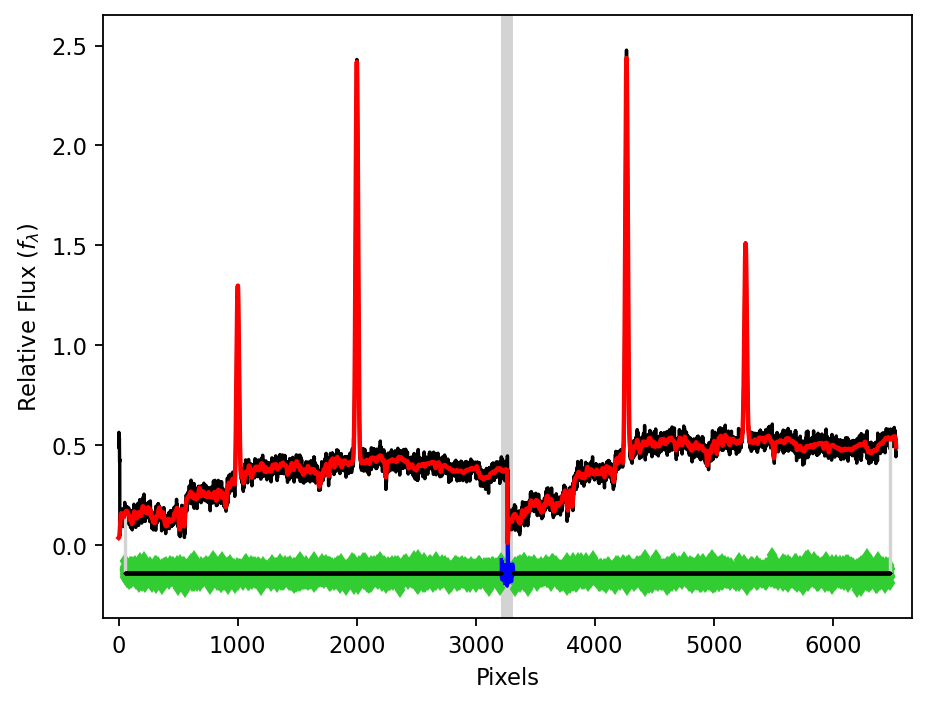

In [14]:
t = clock()
pp = ppxf(sps.templates, galaxy, noise, velscale, start,
            goodpixels=goodpixels, plot=1, moments=moments,
            vsyst=vsyst, mdegree=deg, degree=deg, sky=sky)
print('Elapsed time in pPXF: %.2f s' % (clock() - t))
plt.pause(5);